# Etapa 1
O primeiro passo consiste na instalação do pacote que será responsável pela dinâmica molecular. Descomente a linha abaixo caso o pacote M3L ainda não foi instalado no seu ambiente virtual python.

In [1]:
# carregando sistema físico
from m3l.structure import System as sys
import json
#
system = sys()
system.loadSystem('Ar_100K_1000atm.json')
system.convertUnits()

In [2]:
# definindo o modelo de interação entre os átomos (campo de força)
import m3l.force_field as ff
from m3l.force_field import Intermolecular as interff
class Forces(ff.ForceField):
    def __init__(self):
        super().__init__()
        self.potential(
            interff.site(0.0, 0.2381*self.ECONV, 3.405*self.ACONV),
            interff.site(0.0, 0.2381*self.ECONV, 3.405*self.ACONV),
        )
#        
model = Forces()
model()

array([[0.00000000e+00, 3.79562361e-04, 6.43451746e+00],
       [0.00000000e+00, 3.79562361e-04, 6.43451746e+00]])

In [3]:
#definindo o modelo de interação entre os átomos (campo de força)
#from m3l.molecular_dynamics import ForceField
#class Forces(ForceField):
#    def __init__(self):
#        super().__init__()
#        self.van_der_waals(
#            (1, 0.2381*self.ECONV, 3.405*self.ACONV)
#        )
#        
#model2 = Forces()
#model2()

In [4]:
# definindo o modelo estatístico (ensemble)
from m3l.molecular_dynamics import Ensemble as en
#
force_field = model()
ensemble = en(temp_bath = 100.0, press_bath = 1000.0, timestep = 1.0e-3, force_field = force_field, tstat = 1.0, pstat = 1.0, bfactor = 4.9e-5)
system = ensemble(system)

In [5]:
# executando looping
import time
import csv
import numpy as np
#
n_steps = 100000
i_step = 0
start = time.time()
with open('history.csv', 'w', newline = '') as csvfile1, open('thermodynamics.csv', 'w', newline = '') as csvfile2:
    fieldnames1 = ['time', 'mass', 'x', 'y', 'z']
    writer1 = csv.DictWriter(csvfile1, fieldnames = fieldnames1)
    writer1.writeheader()
    fieldnames2 = ['time', 'volume', 'temperature', 'epotential', 'pressure']
    writer2 = csv.DictWriter(csvfile2, fieldnames = fieldnames2)
    writer2.writeheader()
    for step in range(n_steps):
        system = ensemble(system)
        if step%100 == 0:
            i_step += 1
            writer2.writerow({
                'time': ensemble.dtimestep*step/system.TIMECONV, 
                'volume': np.prod(system.cell)/system.ACONV**3,
                'temperature': system.temperature/system.TEMPCONV,
                'epotential': system.epotential/system.ECONV,
                'pressure': system.pressure/system.PCONV})
            for i, atom in enumerate(system.mat):
                writer1.writerow({
                    'time': ensemble.dtimestep*step/system.TIMECONV,
                    'mass': atom,
                    'x': system.rx[i]/system.ACONV,
                    'y': system.ry[i]/system.ACONV,
                    'z': system.rz[i]/system.ACONV})
           #print(f'Step: {i_step}; Energy: {system.epotential*system.ECONV}')

end = time.time()
print(f'Elapsed time: {end - start} seconds')

Elapsed time: 248.6457450389862 seconds


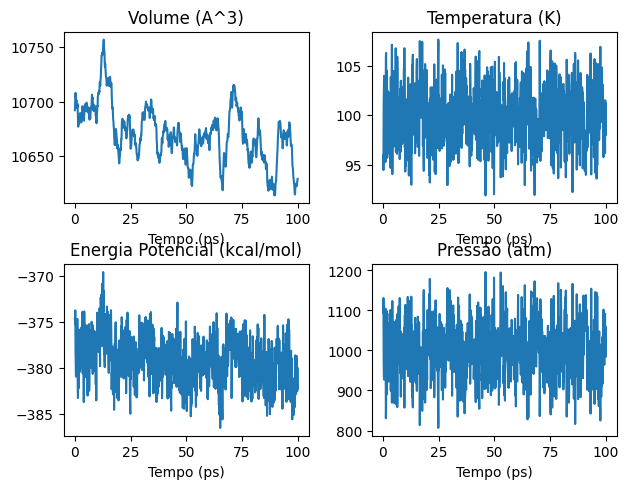

In [6]:
import matplotlib.pyplot as plt
import numpy as np
dataset = np.loadtxt("thermodynamics.csv", dtype=np.float32, delimiter = ",", skiprows=1)
time = [item[0].item() for item in dataset]
vol = [item[1].item() for item in dataset]
temp = [item[2].item() for item in dataset]
epot = [item[3].item() for item in dataset]
press = [item[4].item() for item in dataset]
#plt.plot(time, temp)
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(time, vol)
axs[0, 0].set_title("Volume (A^3)")
axs[0, 1].plot(time, temp)
axs[0, 1].set_title("Temperatura (K)")
axs[1, 0].plot(time, epot)
axs[1, 0].set_title("Energia Potencial (kcal/mol)")
axs[1, 1].plot(time, press)
axs[1, 1].set_title("Pressão (atm)")
fig.tight_layout()
for ax in axs.flat:
    ax.set(xlabel='Tempo (ps)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()
plt.savefig("MD.jpg")

In [7]:
system.convertUnitsInv()
#system.save('system_new.json')